# PDP Assignment #3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Instructions
Train a 3-layer (input, hidden, output) network to classify hand written digits (3 and 5) from the MNIST dataset. Once you set up and trained the network you can choose do either of two things: 

(a) Investigate the performance of the network as a function of the number of hidden units. Make some nice plots. You may also want to investigate other network parameters (e.g. learning rate, simulated annealing). Provide potential explanations for the effects you observe. 

(b) Investigate the hidden layer representations (activation values of hidden units) for input patterns that represent the digits 3 vs. digits 5. This requires reasonable performance of the network. You may also want to investigate how these representations change with learning, e.g., does the average hidden representation for digit 3 become less similar to the average hidden representation for digit 5? Explain what you observe. 

You only have to do either (a) or (b) but you are welcome to complete both exercises.

## Part 1: MNIST Dataset
The [MNSIT dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits, i.e. 60,000 and 10,000 training and testing images, respectively. The black-and-white images have been normalized to fit into a 28x28 pixel bounding box. The challenge of the MNIST dataset is a machine learning classifier (e.g. neural network) to accurately predict the target label (e.g. 0-9) from the input image. 

First we will load the data. To lighten the computational load, we will only use 1000 images per digit.

In [2]:
from sklearn.datasets import fetch_mldata

## Fetch MNIST dataset.
mnist = fetch_mldata("MNIST original")

## Extract data.
data = mnist['data'] / 255
target = mnist['target']

## Restrict dataset.
n_samples = 1000
ix = np.concatenate([np.where(target==i)[0][:n_samples] for i in np.unique(target)])
data = data[ix]
target = target[ix]

To make it clear the data we are looking at, we will plot a composite image of each digit 0-9. We will produce these images by averaging across all individual handwritten digits within each label.

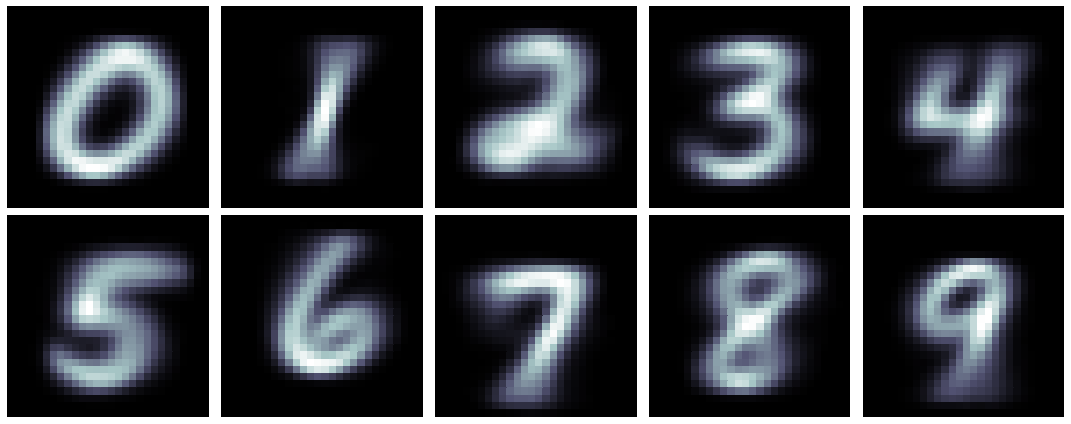

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(2,5,figsize=(15,6))

for i, ax in enumerate(axes.flatten()):
    
    ## Compute mean image.
    avg_img = data[target==i].mean(axis=0)
    
    ## Plot image.
    sns.heatmap(avg_img.reshape(28,28), cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    
plt.tight_layout()

## Part 2: Classifying 3s and 5s
In this first section, we will start with a toy problem: training a model to accurately distinguish 3s and 5s. This simple problem will provide an intuition for the representations of the hidden layer of a neural network. We will proceed in three steps:

1. Develop a simple strategy for classifying 3s and 5s.
2. Demonstrate this strategy using logistic regression.
3. Demonstrate that a simple neural network performs an equivalent strategy.

### a) Building Intuitions
How do we, i.e. humans with expert learning of the Arabic number system, tell handwritten 3s and 5s apart? Simple: we contrast their shapes! Roughly speaking, the digit 3 is composed of two stacked half-circles with the "holes" facing left. Likewise, the digit 5 is also composed of two stacked half-circles but with the bottom half-circle facing left and the top half-circle facing right. This is, of course, a very rough description of the characteristic shape of 3s and 5s (we are ignoring, for example, that the top of the digit 5 is typically flat). But this is a sufficient starting place.

If we were to write a computer program from scratch to distinguish 3s and 5s, a good strategy would be to exploit these differences in shape. Concretely, we could accomplish this by writing a program that assigns high probability of an image being an example of the digit 3 if the image occupies space (i.e. pixels) *uniquely* occupied by 3s, and assigns high probability to an image being an example of the digit 5 if the image occupies space that are *uniquely* occupied by 5s. Note the use of the word *uniquely*. By this we mean that the most informative pixels are those that are typically "activated" only for 3s and 5s. 

How can we identify those pixels most representative of each digit? One simple approach is to subtract a canonical 3 from a canonical 5. We do this below.

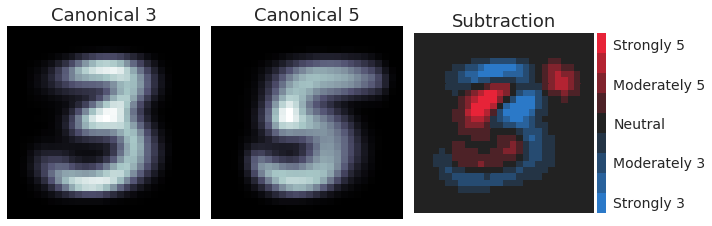

In [4]:
## Reduce to first 1000 3s and 5s.
ix = np.in1d(target, [3,5])
X = data[ix]
Y = target[ix]

## Make average 3 & 5 image.
average_3_img = data[target==3].mean(axis=0).reshape(28,28)
average_5_img = data[target==5].mean(axis=0).reshape(28,28)

## Plot average images.
fig, axes = plt.subplots(1,3,figsize=(10,10/3))
for ax, img, title in zip(axes, [average_3_img, average_5_img], [3,5]):
    sns.heatmap(img, cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Canonical %s' %title)

## Plot subtraction.
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=9, center="dark")
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sub_img = average_5_img-average_3_img
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='Subtraction')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);

plt.tight_layout()

As can plainly be observed, the subtraction reveals those pixels that are strongly representative of the digit 5 (red), strongly representative of the digit 3 (blue), and those that are uninformative (black). It might turn out then that we might be able to solve this classification problem simply by writing a program that, upon reading an example image, classifies the image as the digit 5 or the digit 3 if it has mass in the "red" or "blue" pixels, respectively. 

Though we will not implement this exact algorithm, we will do something conceptually similar below by training a logistic regression classifier. A logistic regression classifier is even simpler than a neural network: it transforms some input image via a set of weights into a binary output. It has no hidden layer with which to perform additional computation. In this way, it is the simplest starting point. 

### b) Logistic Regression Classifier
Below, we train a logistic regression classifier to discriminate between handwritten examples of the digits 3 and 5. Concretely, we will train a set of weights (one per pixel, 28x28 total) to classify images as either 3 or 5. We will divide our dataset of 1000 unique images per digit in half to form training and test sets. Note, the weights are independent of one another (i.e. the weight corresponding to one pixel has no bearing on the weight corresponding to another).

#### Model fitting and performance
Based on the subtraction image above, it is likely that many pixels across images will be uninformative for discriminating between 3s and 5s. As such, we might want to employ *regularization* into our model fitting procedure. Regularization is term that describes a method which forces some or many of the weights to go to 0. This is useful if we think (as we do) that many of the pixels may be uninformative.

Below we train and test several versions of the logistic regression classifier at varying levels of regularization ($\alpha$).

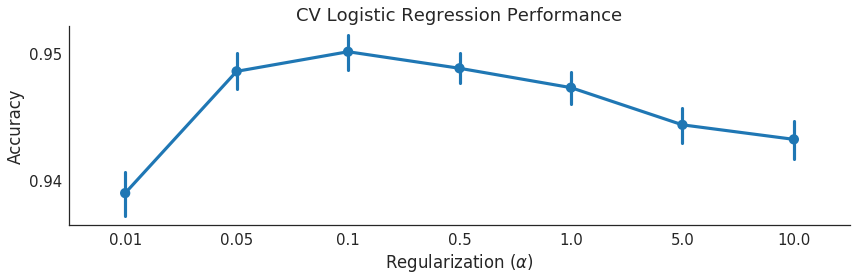

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit

## Define training parameters.
Cs = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.])
train_size = 0.5
test_size = 0.5
n_splits = 50

## Initialize scikit-learn objects.
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, 
                             train_size=train_size, random_state=0)
lrcv = LogisticRegressionCV(Cs=Cs, cv=cv, penalty='l2', random_state=0)

## Fit cross-validated model.
fit = lrcv.fit(X,Y)
scores = DataFrame(fit.scores_[5], columns=fit.Cs_).melt()

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.pointplot('variable','value',data=scores, ax=ax)
ax.set(xlabel=r'Regularization ($\alpha$)', ylabel='Accuracy', yticks=[0.94,0.95],
       title='CV Logistic Regression Performance')
sns.despine()
plt.tight_layout()

As can be observed above, out-of-sample classification accuracy is highest with a moderate level of regularization ($\alpha = 0.1$). We will use this level of regularization in our example below.

It is also worth noting that this classifier achieves approximately 95% classification accuracy. In other words,  simple logistic regression on each pixel can successfully discriminate between 3s and 5s for 19/20 cases! We visualize the weights of this model below. 

#### Latent Representations

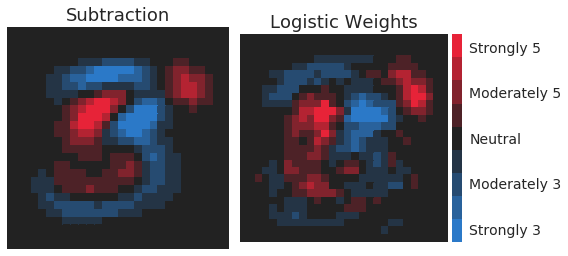

In [6]:
## Extract weights.
w = np.median(fit.coefs_paths_[5][:,Cs==0.1,:-1], axis=0)
w = w.reshape(28,28)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4))

## Plot subtraction.
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Subtraction')

## Plot logistic weights.
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sns.heatmap(w, vmin=-0.4, vmax=0.4, square=True, cmap=cmap, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='Logistic Weights')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);
plt.tight_layout()

In a nice proof of concept, we can observe that the logistic regression classifier is implementing something very similar to our hypothetical classification strategy. In other words, the classifier is finding those pixels most representative of 3s and 5s, respectively, in order to maximize its classification performance. Amazingly, this strategy yields highly accurate performance at approximately 95%! 

### c) Neural Network
Now we can address the question at hand: What does a neural network learn in solving this problem? Is it using a similar strategy or does it come to represent the problem in some other way? 

Before implementing the neural network, we will make an *a priori* prediction. We predict that the neural network will implement an equivalent (if not identical) strategy. In other words, we predict that a neural network will find and represent those pixels most representative of 3s and 5s, respectively, in order to maximize its classification performance. Furthermore, we predict that a neural network can achieve comparable performance to the logistic regression classifier with just *1 hidden layer comprised of 1 node*. 

We make this prediction based on what we know of fully-connected neural network architectures with logistic weights. Simply put, a neural network with 1 hidden layer/1 unit is *identical* to the logistic regression classifier *except* that the activation from the inputs must be routed through one additional node (i.e. the 1 hidden unit) prior to its output. Insofar that this node preserves the information, however, performance will be identical.

#### Model fitting and performance
We train a uniformly connected neural network with 1 unit in 1 hidden layer below. Note that this network utilizes logistic activation functions and gradient descent for optimization (as in PDP). 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

## Split data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5, 
                                                    stratify=Y, random_state=0)

## Initialize neural network.
nn = MLPClassifier((1), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Compute out-of-sample accuracy.
print('Out-of-sample prediction accuracy = %s' %fit.score(X_test, y_test))

Out-of-sample prediction accuracy = 0.946


As predicted, the neural network achieves comparable out-of-sample classification accuracy, i.e. approximately 95%.

The question remains though: are the weights of the network encoding the same information as the logistic regression classifier? In other words, do the representations of the neural network resemble the strategy described above?

#### Predictive weights

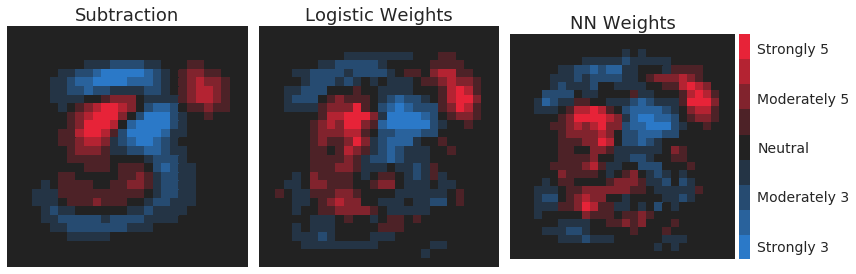

In [8]:
## Extract weights.
input_weights = fit.coefs_[0]
input_weights = -1 * input_weights.reshape(28,28)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot subtraction.
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Subtraction')

## Plot logistic weights.
sns.heatmap(w, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Logistic Weights')

## Plot neural network weights.
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sns.heatmap(input_weights, vmin=-0.4, vmax=0.4, square=True, cmap=cmap, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='NN Weights')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);
plt.tight_layout()

As predicted, the input weights of the neural network (i.e. the weights between input layer and the 1 hidden unit) qualitatively resemble those of the logistic regression classifier. We can quantify the similarity between the logistic regression classifier and neural network by computing their angle using cosine similarity. By definition:

> Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0 degrees is 1, and it is less than 1 for any other angle in the interval $[0,2\pi)$. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors at 90 degrees have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. 

Given two vectors, cosine similarity is defined as:

$$ cos(\theta) = \frac{A \cdot B}{\lVert A \rVert \lVert B \rVert} =
    \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2}\sqrt{\sum_{i=1}^n B_i^2}}$$

In [9]:
from scipy.spatial.distance import cosine
print('Cosine similarity = %0.3f' %(1 - cosine(w.flatten(), input_weights.flatten())))

Cosine similarity = 0.931


This provides strong evidence that indeed the neural network has formed representations that are consistent with the intuitive strategy outlined above. Namely, the neural network comes to represent those pixels that are most representative of 3s and 5s, respectively. 

## Part 3: Classifying all digits

Above we offered a simple strategy for discriminating between the digits 3 and 5, a strategy that seemed to be employed by both a logistic regression classifier and a simple neural network. But what about the harder problem of classifying *all Arabic digits* (0-9)?  

In this next section, we demonstrate the following:

1. Classifying all digits (0-9) is a much harder problem that our simple neural network will fail.
2. More complex neural networks can achieve reasonable performance on this classification problem.
3. More complex neural networks are employing more complex strategies as evidenced by their latent representations. 

### a) The Hard Problem

Above we proposed a simple strategy for binary classification: identify those pixels most representative of either 3 or 5. But what if we have multiple classes? Are the pixels most informative for discriminating 3 from 5 still equally useful in discriminating 3 from 5 and 8? What about discriminating 3 from [0, 1, 2, 4, 5, 6, 7, 8, 9]? Intuition suggests that this problem should be much more challenging. 

One way to show the difficulty of this problem is to project all 10,000 images into a lower-dimensional space using principal components analysis (PCA). We might predict that if there are uniquely representative pixels for each digit, then PCA will be able to cluster digits into non-overlapping regions of a two-dimensional pixel sub-space.

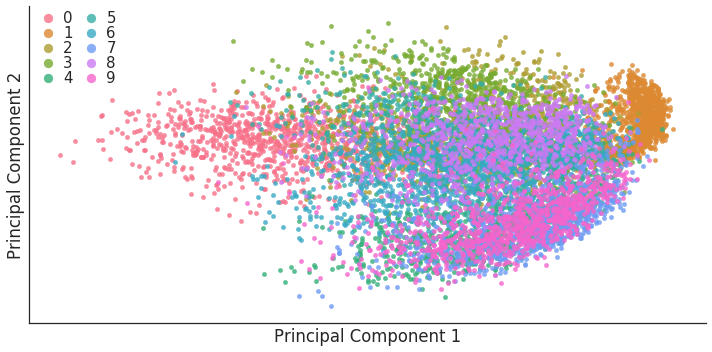

In [10]:
## Compute principal components.
U, S, Vt = np.linalg.svd( np.cov(data.T) )

## De-mean data.
X0 = np.apply_along_axis(lambda arr: arr - arr.mean(), 0, data)

## Project onto first two principal components.
X0_proj = X0 @ U[:,:2]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,5))

## Iteratively plot.
for i, color in enumerate(sns.husl_palette(n_colors=10).as_hex()):
    
    ax.scatter(*X0_proj[target==i].T, s=20, color=color, label=i, alpha=0.8)
    
## Add info.
ax.set(xticks=[], xlabel='Principal Component 1', yticks=[], ylabel='Principal Component 2')
ax.legend(loc=2, ncol=2, markerscale=2, borderpad=-0.25, labelspacing=0, 
          columnspacing=0.25, handletextpad=0)

sns.despine()
plt.tight_layout()

It should be obvious from the above that the digit classes are largely overlapping in a lower-dimensional subspace. With the exception of maybe 0s (red) and 1s (orange), the clusters of digits are overlaid on top of one another. This is highly suggestive that simple classification strategies (such as the subtraction strategy) are likely to fail. 

We can demonstrate this by using the same neural network as above (i.e. 1 hidden layer / 1 unit). If the subtraction strategy cannot adequately classify digits 0-9, then we should expect performance of this neural network to drop precipitously.  

In [11]:
## Split data.
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.5, test_size=0.5, 
                                                    stratify=target, random_state=0)

## Initialize neural network.
nn = MLPClassifier((1), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.01, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Compute out-of-sample accuracy.
print('Out-of-sample prediction accuracy = %s' %fit.score(X_test, y_test))

Out-of-sample prediction accuracy = 0.2132


This is in fact what we observe. Classification accuracy drops from approximately 95% to a little over 20%. Though this is better than chance (10%), this is still horrific performance. Can we build a neural network that does better?

### b) Neural Network with Multiple Units
Below we fit and test the performance of a handful of neural networks. All of the fitted networks have only 1 hidden layer, but vary in the number of units. Specifically, we test networks with 1-10 units in the hidden layer.

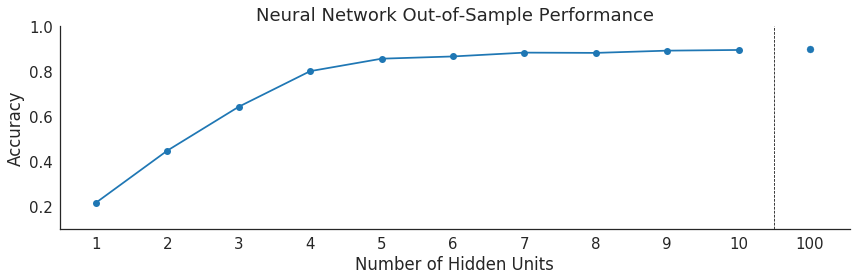

In [12]:
## Define sizes.
sizes = np.arange(10) + 1
sizes = np.append(sizes, 100)

## Main loop.
scores = np.zeros_like(sizes, dtype=float)

for i, n in enumerate(sizes):

    ## Initialize neural network.
    nn = MLPClassifier((n), activation='logistic', solver='sgd', learning_rate='constant', 
                       alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

    ## Train.
    fit = nn.fit(X_train, y_train)
    
    ## Compute out-of-sample accuracy.
    scores[i] = fit.score(X_test, y_test)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(sizes[:-1], scores[:-1], marker='o')
ax.scatter(11, scores[-1], marker='o')
ax.vlines(10.5, 0.1, 1, linestyle='--', lw=0.75)
ax.set(xticks=np.arange(11)+1, xticklabels=np.append(np.arange(10)+1,100), 
       xlabel='Number of Hidden Units', ylim=(0.1,1), ylabel='Accuracy',
       title='Neural Network Out-of-Sample Performance')

sns.despine()
plt.tight_layout()

Increasing the number of units in the single hidden layer dramatically increases performance at first (from 1 to 5 units). Classification accuracy climbs from approximately 20% to over 80% (5 total units), but quickly tapers off following. Below we will explore the representations of the 5-unit network. Importantly, we should note that the network does not achieve comparable performance as for the first problem (80% vs. 95%). This highlights how much more challenging the 10-digit classification problem is than the 2-digit classification problem!

### c) Latent Representations
Next we plot the representations learned by the 5-unit hidden layer network. Specifically, we plot the weights connecting the input and hidden layers. 

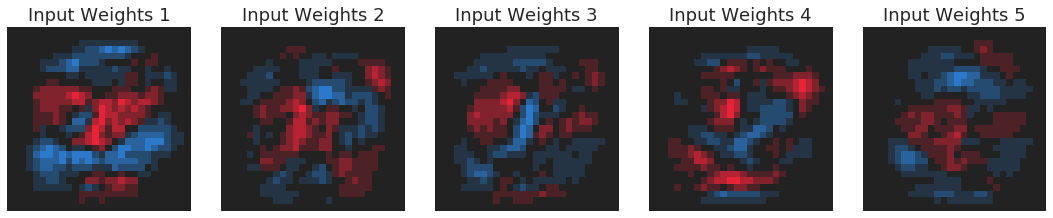

In [13]:
## Initialize neural network.
nn = MLPClassifier((5), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Extract weights.
input_weights = fit.coefs_[0].T

## Initialize canvas.
fig, axes = plt.subplots(1,5,figsize=(15,3))

for ax, w, i in zip(axes.flatten(), input_weights, np.arange(5)+1):
        
    ## Plot image.
    sns.heatmap(w.reshape(28,28), cmap=cmap, center=0, square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Input Weights %s' %i)
    
plt.tight_layout()

What should be apparent in inspecting the input weights to each unit of the hidden layer is that they are no longer immediately interpretable as they were in discriminating between 3s and 5s. In other words, the network is not simply learning which pixels are most representative of each digit. 

How can we make sense of these? To start, we can visualize the output weights connecting the hidden and output layers. These weights represent the strength of connections between the hidden notes (and their associated representations, visualized above) and the outputs corresponding to each digit, 0-9.

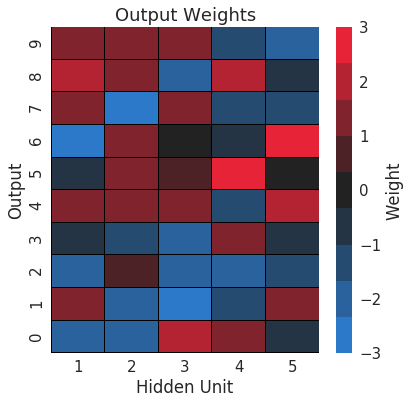

In [14]:
## Extract output weights.
output_weights = fit.coefs_[1].T

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,6))

sns.heatmap(output_weights, cmap=cmap, vmin=-3, vmax=3, linewidths=0.05, linecolor='k',
            xticklabels=np.arange(5)+1, cbar_kws=dict(label='Weight'), ax=ax)
ax.set(xlabel='Hidden Unit', ylabel='Output', title='Output Weights')
ax.invert_yaxis()

To reiterate, the plot above visualizes the weights connecting the hidden layer to the output layer. In the simplest terms, what the plot above shows are the combinations of hidden weight activations/deactivations necessary to maximize the likelihood of the output layer predicting a particular digit. (Because the hidden units are logistic, i.e. in the range of [0, 1], positive and negative weights always correspond to activations and deactivations, respectively, in the output layer.)

To elaborate, let us look at a particular example. The output weights terminating on the 2-output node are all negative except for that weight projecting from the 2nd hidden unit (see figure above to confirm). What this translates to is that, for the network to predict the digit 2, hidden units [1, 3, 4, 5] need to be deactivated and hidden unit 2 should be activated. 

What could cause this pattern of activation in the hidden units? The answer is an input that is congruent with the latent representation (i.e. the weights) of the 2nd hidden unit and incongruent with the others. We can easily determine what such an input should look like by projecting this pattern of activation of the hidden units back onto the input weights.

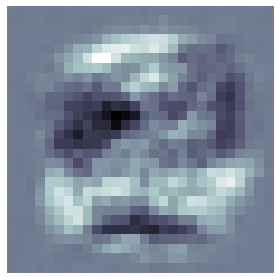

In [15]:
## Define hidden unit activation.
activation = output_weights[2]    # Corresponds to output digit 2.

## Project onto input weights.
pattern = activation @ input_weights

## Plot.
fig, ax = plt.subplots(1,1,figsize=(4,4))
sns.heatmap(pattern.reshape(28,28), cmap='bone', cbar=False, ax=ax)
ax.set(xticks=[], yticks=[])
plt.tight_layout()

Though it may be slightly difficult to make out, the image above looks very similar to a corrupted version of the digit 2! In other words, we have found that the superposition of various combinations of the abstract representations of the hidden layers actually correspond to the digits! 

To demonstrate this is not simply subjective, we can demonstrate that the pattern above really does correspond to the digit 2 by finding which digit (computed from averaging all data within a digit) is most similar to the pattern above.

In [16]:
## Compute cosine similarities.
digits = np.unique(target)
similarities = [1 - cosine(data[target==i].mean(axis=0), pattern) for i in digits]

## Find most similar.
print('Most similar digit: %0.0f' %digits[np.argmax(similarities)])

Most similar digit: 2


We can also demonstrate this by having the network predict the likelist digit from the pattern.

In [17]:
print('Likeliest digit: %0.0f' %fit.predict(pattern.reshape(-1,1).T))

Likeliest digit: 2


Thus in moving from solving the easier problem to the harder problem, the latent representations of the network have gone from simple representations (literally mapping pixels to classes) to more complex representations whose combinatorics predict digit classes. 

These combinations also allowing us to explore which representations are most similar according to the network. We project the output weights into a lower dimensional space using PCA.

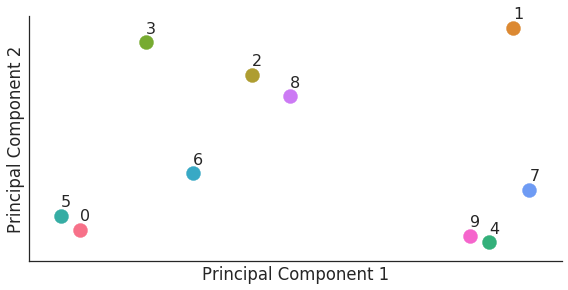

In [18]:
## Project output weights.
U, S, V = np.linalg.svd( np.cov(output_weights.T) )
w0_proj = np.apply_along_axis(lambda arr: arr - arr.mean(), 0, output_weights) @ U[:,:2]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Iteratively plot.
for i, color in enumerate(sns.husl_palette(n_colors=10).as_hex()):
    
    ax.scatter(*w0_proj[i].T, s=200, color=color)
    ax.text(*w0_proj[i].T + [0,0.2], i, fontsize=16)
    
## Add info.
ax.set(xticks=[], xlabel='Principal Component 1', yticks=[], ylabel='Principal Component 2')


sns.despine()
plt.tight_layout()

We find that the network finds 4, 7, 9 relatively similar, and 0, 5 similar. This actually makes a lot of sense given the geometry of these shapes. This can also be predict from the output weights above.